# Communities and Crime

## Notebook Setup and Loading Data

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, LassoCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import PolynomialFeatures

from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.features import RadViz

In [2]:
df = pd.read_csv('/kaggle/input/crime-data/communities.data')
with open('/kaggle/input/crime-data/communities.names', 'r') as file:
    file_contents = file.read()

print(file_contents)

Title: Communities and Crime

Abstract: Communities within the United States. The data combines socio-economic data 
from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime 
data from the 1995 FBI UCR.

-----------------------------------------------------------------------------------------

Data Set Characteristics:  Multivariate
Attribute Characteristics: Real
Associated Tasks: Regression
Number of Instances: 1994
Number of Attributes: 128
Missing Values? Yes
Area: Social
Date Donated: 2009-07-13

-----------------------------------------------------------------------------------------

Source:

Creator: Michael Redmond (redmond 'at' lasalle.edu); Computer Science; La Salle 
University; Philadelphia, PA, 19141, USA
-- culled from 1990 US Census, 1995 US FBI Uniform Crime Report, 1990 US Law 
Enforcement Management and Administrative Statistics Survey, available from ICPSR at U 
of Michigan.
-- Donor: Michael Redmond (redmond 'at' lasalle.edu); Computer

In [3]:
df.head(5)
#No headers. Nothing to identify the data

,8,?,?.1,Lakewoodcity,1,0.19,0.33,0.02,0.9,0.12,...,0.12.2,0.26.1,0.2.1,0.06.3,0.04.2,0.9.1,0.5.2,0.32.2,0.14.3,0.2.2
0,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.0,?,0.67
1,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.0,?,0.43
2,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.0,?,0.12
3,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.0,?,0.03
4,6,?,?,SouthPasadenacity,1,0.02,0.28,0.06,0.54,1.00,...,0.01,0.58,0.10,?,?,?,?,0.0,?,0.14


#### Assigning Column Names to Communities Dataset

In [4]:
#Function to extract column names from the communities.names file

def extract_column_names(filename):
    """
    Extracts column names from a file where each column name is prefixed with '@attribute'
    """
    column_names = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('@attribute'):
                # Extract the attribute name
                parts = line.split()
                if len(parts) > 1:
                    column_name = parts[1]
                    column_names.append(column_name)
    return column_names

column_names = extract_column_names('/kaggle/input/crime-data/communities.names')

df.columns = column_names                   

In [5]:
df.head(5)

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.0,?,0.67
1,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.0,?,0.43
2,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.0,?,0.12
3,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.0,?,0.03
4,6,?,?,SouthPasadenacity,1,0.02,0.28,0.06,0.54,1.00,...,0.01,0.58,0.10,?,?,?,?,0.0,?,0.14


#### Cleaning Data

In [6]:
#Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

In [7]:
df.dtypes

state                    int64
county                  object
community               object
communityname           object
fold                     int64
                        ...   
LemasPctPolicOnPatr     object
LemasGangUnitDeploy     object
LemasPctOfficDrugUn    float64
PolicBudgPerPop         object
ViolentCrimesPerPop    float64
Length: 128, dtype: object

In [8]:
#Converting data types specified in communities.names file under "Attribute Information" section 
# List of columns not to convert
columns_not_to_convert = ['state', 'county', 'community', 'communityname', 'fold','LemasGangUnitDeploy']

# Converting all other columns to float64 so can be used for analysis 
for column in df.columns:
    if column not in columns_not_to_convert:
        df[column] = df[column].astype(float)

In [9]:
#No duplicates
duplicate_rows = df.duplicated()
df[duplicate_rows]

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop


In [10]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

#Drop columns with a high number of missing values
high_missing_cols = missing_values[missing_values > 1000].index
df_cleaned = df.drop(columns=high_missing_cols)

In [11]:
# For the column with only one missing value, fill it with the median
median_imputer = SimpleImputer(strategy='median')
df_cleaned['OtherPerCap'] = median_imputer.fit_transform(df_cleaned[['OtherPerCap']])

# Check for any categorical columns remaining
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# Since 'communityname' is a categorical column that likely has a high cardinality, 
# it might not be useful for the model, so we drop it.
df_cleaned.drop(columns=categorical_cols, inplace=True)

# Split the data into features and target
X = df_cleaned.drop(columns=['ViolentCrimesPerPop'], axis=1)
y = df_cleaned['ViolentCrimesPerPop']

#Show list of features, Target = ViolentCrimesPerPop'
feature_names = X.columns.tolist()
feature_names

['state',
 'fold',
 'population',
 'householdsize',
 'racepctblack',
 'racePctWhite',
 'racePctAsian',
 'racePctHisp',
 'agePct12t21',
 'agePct12t29',
 'agePct16t24',
 'agePct65up',
 'numbUrban',
 'pctUrban',
 'medIncome',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'medFamInc',
 'perCapInc',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'OtherPerCap',
 'HispPerCap',
 'NumUnderPov',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctNotHSGrad',
 'PctBSorMore',
 'PctUnemployed',
 'PctEmploy',
 'PctEmplManu',
 'PctEmplProfServ',
 'PctOccupManu',
 'PctOccupMgmtProf',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'TotalPctDiv',
 'PersPerFam',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMomYoungKids',
 'PctWorkMom',
 'NumIlleg',
 'PctIlleg',
 'NumImmig',
 'PctImmigRecent',
 'PctImmigRec5',
 'PctImmigRec8',
 'PctImmigRec10',
 'PctRecentImmig',
 'PctRecImmig5',
 'PctRecImmig8',
 'PctRecImmi

In [12]:
df.dtypes

state                    int64
county                  object
community               object
communityname           object
fold                     int64
                        ...   
LemasPctPolicOnPatr    float64
LemasGangUnitDeploy     object
LemasPctOfficDrugUn    float64
PolicBudgPerPop        float64
ViolentCrimesPerPop    float64
Length: 128, dtype: object

#### Create Train/Test Splits From Cleaned Data

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Output the shape of the resulting dataframes
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((1594, 102), (399, 102), (1594,), (399,))

## Exploratory Data Analysis

#### General Statistical Information

In [14]:
#Look at basic stats for each column used for prediction. Excludes columns that are only descriptive
df.drop(columns=['state', 'fold']).describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
count,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,...,318.000000,1993.000000,1993.000000,1993.000000,318.000000,318.000000,318.000000,1993.000000,318.000000,1993.000000
mean,0.057526,0.463462,0.179709,0.753643,0.153698,0.144009,0.424260,0.493879,0.336287,0.423216,...,0.306038,0.065203,0.232840,0.161666,0.163428,0.076824,0.697956,0.093939,0.195252,0.237998
std,0.126903,0.163731,0.253480,0.244079,0.208929,0.232549,0.155223,0.143599,0.166543,0.179216,...,0.227240,0.109480,0.203142,0.229111,0.215038,0.140413,0.213981,0.240335,0.164948,0.233042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,...,0.140000,0.020000,0.100000,0.020000,0.040000,0.020000,0.620000,0.000000,0.110000,0.070000
50%,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,0.290000,0.420000,...,0.260000,0.040000,0.170000,0.070000,0.080000,0.030000,0.750000,0.000000,0.155000,0.150000
75%,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,0.360000,0.530000,...,0.397500,0.070000,0.280000,0.190000,0.197500,0.060000,0.840000,0.000000,0.220000,0.330000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


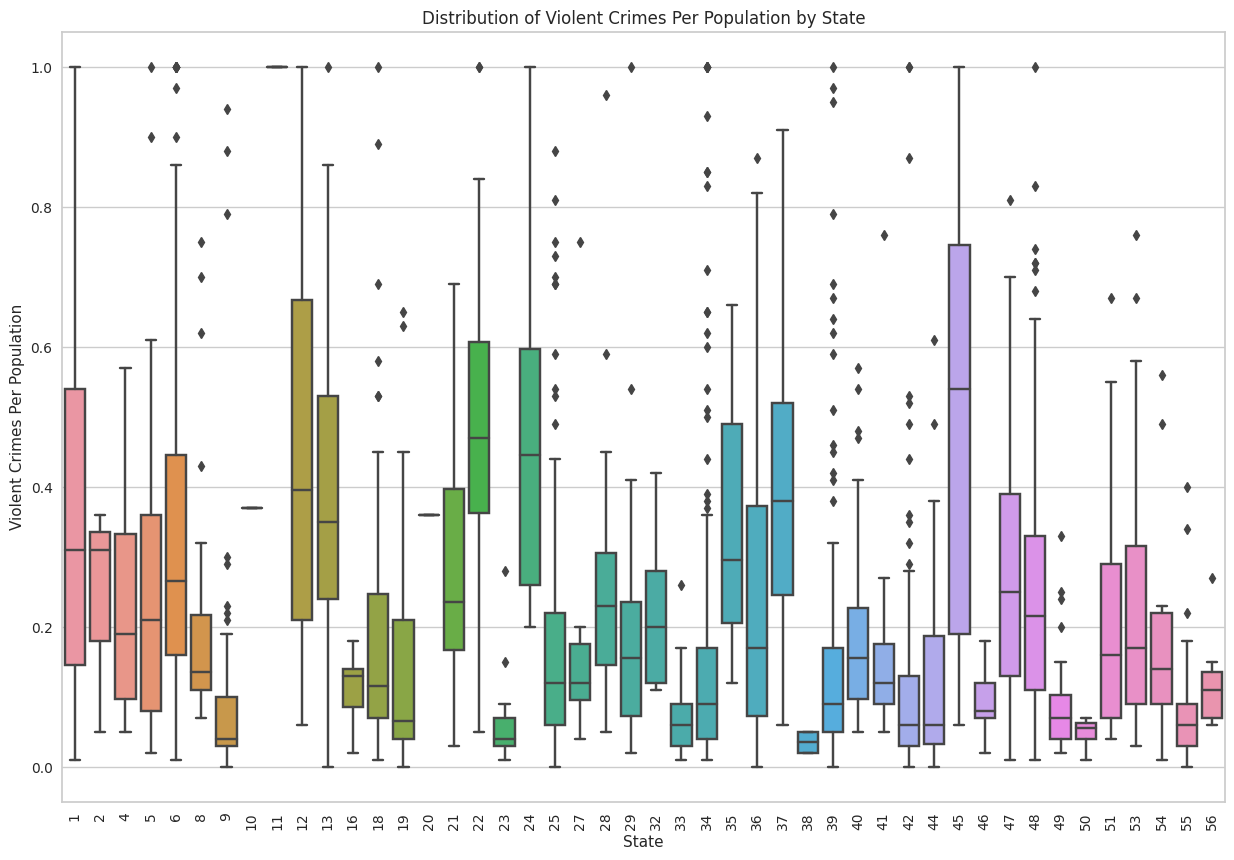

In [15]:
#Create a boxplot to look at distrubtion of violent crime for each state

plt.figure(figsize=(15, 10))  # Adjust the size of the plot as needed
sns.boxplot(x='state', y='ViolentCrimesPerPop', data=df)

plt.xlabel('State')
plt.ylabel('Violent Crimes Per Population')
plt.title('Distribution of Violent Crimes Per Population by State')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [16]:
#Data seems to skip some states. Maybe uses territories. Otherwise unsure why states go up to 56
unique_states = df['state'].unique()
print(sorted(unique_states))

[1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56]


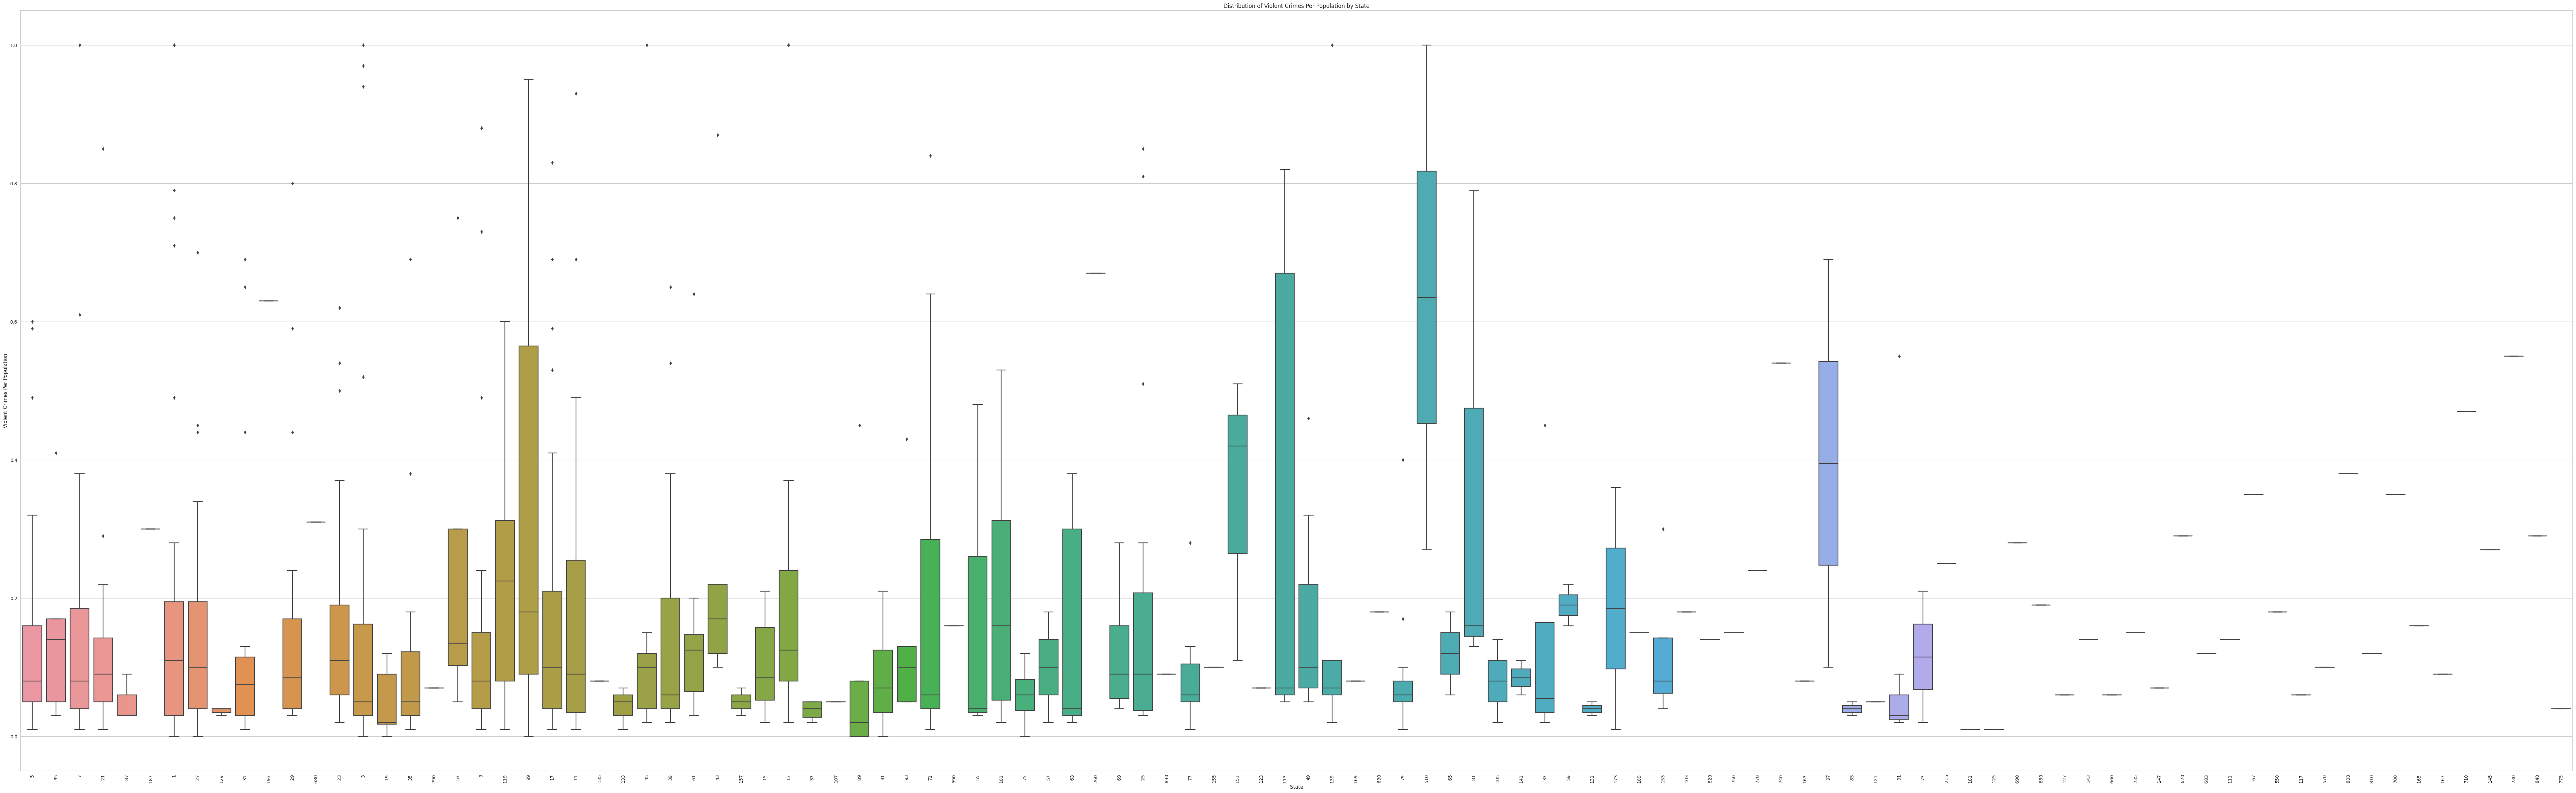

In [17]:
#Create a boxplot to look at distrubtion of violent crime for each county.
#Needs tinkering to plot size and label size to better visualize the data. 

plt.figure(figsize=(100, 30))  # Adjust the size of the plot as needed
sns.boxplot(x='county', y='ViolentCrimesPerPop', data=df)

plt.xlabel('State')
plt.ylabel('Violent Crimes Per Population')
plt.title('Distribution of Violent Crimes Per Population by State')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

### Regression

In [18]:
#Generate correlation coefficients between all variables and violent crime

# Select only columns of float64 type. Will only use non descriptive data.
float_columns = df.select_dtypes(include=['float64'])

correlation_matrix = float_columns.corr()

# Extract correlations with 'ViolentCrimesPerPop'
violent_crimes_correlation = correlation_matrix['ViolentCrimesPerPop']

print(violent_crimes_correlation)

population             0.367346
householdsize         -0.034995
racepctblack           0.631279
racePctWhite          -0.684787
racePctAsian           0.037609
                         ...   
PolicOperBudg          0.337912
LemasPctPolicOnPatr   -0.079933
LemasPctOfficDrugUn    0.348784
PolicBudgPerPop        0.095172
ViolentCrimesPerPop    1.000000
Name: ViolentCrimesPerPop, Length: 122, dtype: float64


In [19]:
correlation_matrix.style.background_gradient(cmap='coolwarm')

In [20]:
corr_matrix = df_cleaned.corr().abs()
corr_matrix
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
print("Features that are highly correlated with each other:")
high_corr_var

Features that are highly correlated with each other:


[('population', 'numbUrban'),
 ('population', 'NumUnderPov'),
 ('population', 'NumIlleg'),
 ('population', 'HousVacant'),
 ('population', 'NumInShelters'),
 ('householdsize', 'PersPerFam'),
 ('householdsize', 'PersPerOccupHous'),
 ('householdsize', 'PersPerOwnOccHous'),
 ('racepctblack', 'PctIlleg'),
 ('racePctWhite', 'PctIlleg'),
 ('racePctHisp', 'PctSpeakEnglOnly'),
 ('racePctHisp', 'PctNotSpeakEnglWell'),
 ('racePctHisp', 'PctPersDenseHous'),
 ('agePct12t21', 'agePct12t29'),
 ('agePct12t21', 'agePct16t24'),
 ('agePct12t29', 'agePct16t24'),
 ('agePct65up', 'pctWWage'),
 ('agePct65up', 'pctWSocSec'),
 ('numbUrban', 'NumUnderPov'),
 ('numbUrban', 'NumIlleg'),
 ('numbUrban', 'HousVacant'),
 ('numbUrban', 'NumInShelters'),
 ('medIncome', 'medFamInc'),
 ('medIncome', 'perCapInc'),
 ('medIncome', 'whitePerCap'),
 ('medIncome', 'RentLowQ'),
 ('medIncome', 'RentMedian'),
 ('medIncome', 'RentHighQ'),
 ('medIncome', 'MedRent'),
 ('pctWWage', 'pctWSocSec'),
 ('pctWWage', 'PctEmploy'),
 ('pctWIn

In [21]:
'''
def remove_collinear_features(x, threshold):
    # Calculate the correlation matrix
    corr_matrix = X.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                
            #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    X = X.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return X
'''

'\ndef remove_collinear_features(x, threshold):\n    # Calculate the correlation matrix\n    corr_matrix = X.corr()\n    iters = range(len(corr_matrix.columns) - 1)\n    drop_cols = []\n\n    # Iterate through the correlation matrix and compare correlations\n    for i in iters:\n        for j in range(i+1):\n            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]\n            col = item.columns\n            row = item.index\n            val = abs(item.values)\n\n            # If correlation exceeds the threshold\n            if val >= threshold:\n                # Print the correlated features and the correlation value\n                \n            #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))\n                drop_cols.append(col.values[0])\n\n    # Drop one of each pair of correlated columns\n    drops = set(drop_cols)\n    X = X.drop(columns=drops)\n    print(\'Removed Columns {}\'.format(drops))\n    return X\n'

In [22]:
'''print("Removing Correlated Features")
# Pass DataFrame and Threshold value 
remove_collinear_features(X_train,0.80)'''

'print("Removing Correlated Features")\n# Pass DataFrame and Threshold value \nremove_collinear_features(X_train,0.80)'

In [23]:
# Sort the correlations based on their absolute values in order of strongest correlations
# Need to drop ViolentCrimesPerPop
violent_crimes_correlation.abs().sort_values(ascending=False)

ViolentCrimesPerPop    1.000000
PctKids2Par            0.738445
PctIlleg               0.737965
PctFam2Par             0.706713
racePctWhite           0.684787
                         ...   
householdsize          0.034995
PolicAveOTWorked       0.033476
PctWorkMomYoungKids    0.022431
PctVacMore6Mos         0.021212
PctSameState85         0.019464
Name: ViolentCrimesPerPop, Length: 122, dtype: float64

### Visualization

<Axes: ylabel='ViolentCrimesPerPop'>

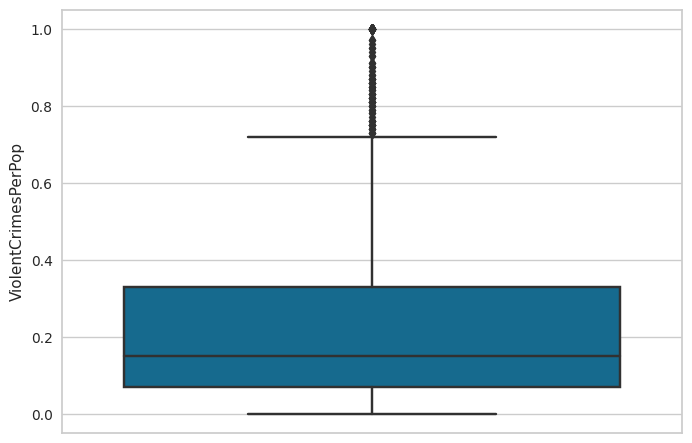

In [24]:
sns.boxplot(y='ViolentCrimesPerPop', data=df)

# My initial attempt to explain the results: 
# Boxplot shows the 'ViolentCrimesPerPop' distribution, with a median of 0.2 and the middle 50% of data between the 25th and 75th percentiles.
# Outliers are present above the upper whisker, suggesting a right-skewed distribution?

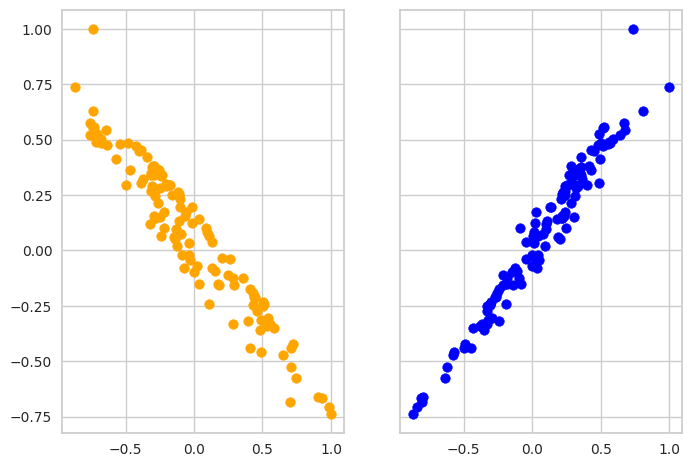

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(x="PctKids2Par", y="ViolentCrimesPerPop", data=correlation_matrix, c='orange')
ax2.scatter(x="PctIlleg", y="ViolentCrimesPerPop", data=correlation_matrix, c='blue')
plt.show()

#### Linear Regression (OLS)

In [26]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 
from sklearn.linear_model import LinearRegression 

model = LinearRegression() 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

# My initial attempt to explain the results: 
# R-squared of 0.657 indicates that the model explains about 65.7% of the variance in 'ViolentCrimesPerPop', indicating a moderate to good fit. 
#The Mean Squared Error of 0.019 suggests the model's predictions are relatively close to actual values, indicating a good fit.

r2=0.657 MSE=0.019


##### L2 and L1 Regularization for Ridge (L2) and Lasso (L1) Regression

In [27]:
# L2 and L1 Regularization 
alphas = np.logspace(-10, 0, 200)

### Ridge Regression

In [28]:
from sklearn.linear_model import RidgeCV 

model = RidgeCV(alphas=alphas) 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.alpha_))

# My initial attempt to explain the results: 
# #Alpha of 1.000 shows a good balance between complexity and prediction accuracy, #explaining 66.4% of the variance and achieving a low mean squared error of 0.018, indicating effective predictive performance.

r2=0.664 MSE=0.018 alpha=1.000


In [29]:
from sklearn.linear_model import LassoCV 

model = LassoCV(alphas=alphas, max_iter=10000) 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.alpha_))

r2=0.665 MSE=0.018 alpha=0.000


#### Elastic Net Model
- expands regression to penalize complexity and minimize overfitting

In [30]:
from sklearn.linear_model import ElasticNetCV

model = ElasticNetCV(alphas=alphas, max_iter=10000)
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

r2=0.665 MSE=0.018


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


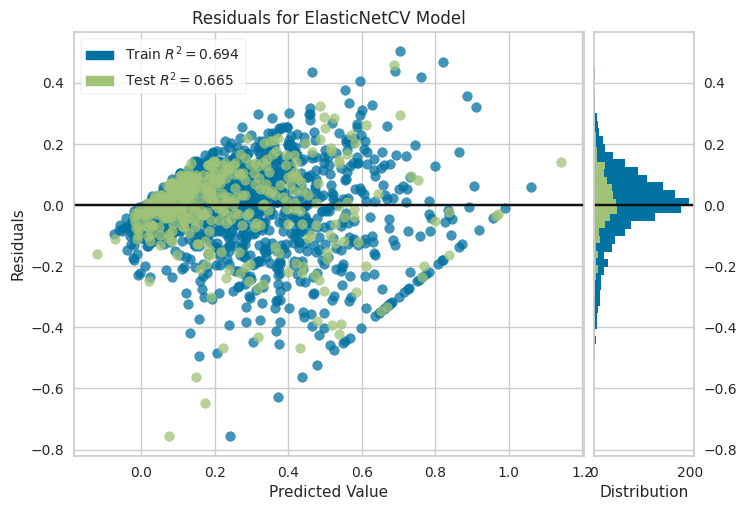

<Axes: title={'center': 'Residuals for ElasticNetCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [31]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

Ideally, the datapoints should be randomly distributed around the horizontal axis and there shouldn't be any pattern. This suggests a on-linear model may be better.

In [32]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor() 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

r2=0.639 MSE=0.020


Random Forest Regressor achieves a worse R2 score.

In [33]:
model = Pipeline([
    ('poly', PolynomialFeatures(2)), 
    ('ridge', RidgeCV(alphas=alphas)),
])

model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.named_steps['ridge'].alpha_))

r2=0.577 MSE=0.023 alpha=1.000


In [34]:
model = Pipeline([
    ('poly', PolynomialFeatures(3)), 
    ('ridge', RidgeCV(alphas=alphas)),
])

model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.named_steps['ridge'].alpha_))

r2=-0.852 MSE=0.100 alpha=1.000


In [35]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor() 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

r2=0.445 MSE=0.030


In [36]:
from sklearn.linear_model import BayesianRidge

model = BayesianRidge() 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

r2=0.663 MSE=0.018


In [37]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.44498241062611277

None of these models are performing particularly well. We may need to be more selective in our features or treat outliers in order to increase accuracy.

In [38]:
def reject_outliers(df):
 u = np.mean(df_cleaned['ViolentCrimesPerPop'])
 s = np.std(df_cleaned['ViolentCrimesPerPop'])
 df_filtered = df_cleaned[(df_cleaned['ViolentCrimesPerPop']>(u-2*s)) & (df_cleaned['ViolentCrimesPerPop']<(u+2*s))]
 return df_filtered

df=reject_outliers(df)
X = df.drop(columns=['ViolentCrimesPerPop'], axis=1)
y = df['ViolentCrimesPerPop']

In [39]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Output the shape of the resulting dataframes
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((1501, 102), (376, 102), (1501,), (376,))

In [40]:
from sklearn.linear_model import LassoCV 

model = LassoCV(alphas=alphas, max_iter=10000) 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.alpha_))

r2=0.605 MSE=0.012 alpha=0.000


In [41]:
#Removing outliers seems to have lowered the r2 score-- maybe simply because we reduced the amount of data?